In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import models,transforms
from torchvision.datasets import ImageFolder

In [2]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

# Load data

- Dataset can be downloaded [here](https://www.kaggle.com/c/dogs-vs-cats/data).

In [3]:
path = 'C:/Users/Yeonkang/Desktop/Deep_Learning/Image_Recognition/Vanilla_CNN/Python/data/dogsandcats/trainandvalid'

In [4]:
simple_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
train = ImageFolder(os.path.join(path,'train'), simple_transform)
valid = ImageFolder(os.path.join(path,'valid'), simple_transform)

In [5]:
train_data_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=3)
valid_data_loader = torch.utils.data.DataLoader(valid, batch_size=16, shuffle=True, num_workers=3)

# Adjust VGG16

## Change *out_features* of the last linear layer

In [ ]:
vgg = models.vgg16(pretrained=True)
vgg

In [ ]:
for param in vgg.features.parameters():
    param.requires_grad = False
    
vgg.classifier[6].out_features = 2

In [ ]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    
    for batch_idx,(data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data,target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output, target, reduction='mean').data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss.item()/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
if is_cuda:
    vgg = vgg.cuda()

In [ ]:
optimizer = optim.SGD(vgg.classifier.parameters(), lr=0.0001, momentum=0.5)
train_losses,train_accuracy = [],[]
val_losses,val_accuracy = [],[]

for epoch in range(1,10):
    train_epoch_loss,train_epoch_accuracy = fit(epoch, vgg, train_data_loader, phase='training')
    val_epoch_loss,val_epoch_accuracy = fit(epoch, vgg, valid_data_loader, phase='validation')
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

In [ ]:
plt.plot(range(1,len(train_losses)+1),train_losses, 'bo', label='train')
plt.plot(range(1,len(val_losses)+1),val_losses, 'r', label='validation')
plt.title('Loss')
plt.legend()

In [ ]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, 'bo', label='train')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy, 'r', label='validation')
plt.title('Accuracy')
plt.legend()

## Change *p* of dropout

In [ ]:
for layer in vgg.classifier.children():
    if type(layer) == nn.Dropout:
        layer.p = 0.2

In [ ]:
train_losses,train_accuracy = [],[]
val_losses,val_accuracy = [],[]

for epoch in range(1,3):
    train_epoch_loss,train_epoch_accuracy = fit(epoch, vgg, train_data_loader, phase='training')
    val_epoch_loss,val_epoch_accuracy = fit(epoch, vgg, valid_data_loader, phase='validation')
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

## Data augmentation

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean,std = np.array([0.485,0.456,0.406]),np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)

In [ ]:
imshow(train[50][0]) #original data

In [ ]:
aug_transform1 = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=1), transforms.ToTensor(),
                                     transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
train = ImageFolder(os.path.join(path,'train'), aug_transform1)
imshow(train[50][0]) #horizontally flipped image

In [ ]:
aug_transform2 = transforms.Compose([transforms.Resize((224,224)), transforms.RandomRotation(180), transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
train = ImageFolder(os.path.join(path,'train'), aug_transform2)
imshow(train[50][0]) #image rotated by 180 degree

- Code for explaining how do *RandomHorizontalFlip* and *RandomRotation* work

In [ ]:
aug_transform = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(0.2), 
                                    transforms.ToTensor(), transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])
train = ImageFolder(os.path.join(path,'train'), aug_transform)
valid = ImageFolder(os.path.join(path,'valid'), aug_transform)

In [ ]:
train_data_loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True, num_workers=3)
valid_data_loader = torch.utils.data.DataLoader(valid, batch_size=16, shuffle=True, num_workers=3)

In [ ]:
train_losses,train_accuracy = [],[]
val_losses,val_accuracy = [],[]

for epoch in range(1,3):
    train_epoch_loss,train_epoch_accuracy = fit(epoch, vgg, train_data_loader, phase='training')
    val_epoch_loss,val_epoch_accuracy = fit(epoch, vgg, valid_data_loader, phase='validation')
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

# Calculate pre-convoluted features

In [6]:
vgg = models.vgg16(pretrained=True)
if is_cuda:
    vgg = vgg.cuda()

In [7]:
features = vgg.features
for param in features.parameters():
    param.requires_grad = False
    
vgg.classifier[6].out_features = 2

In [8]:
train_data_loader = torch.utils.data.DataLoader(train, batch_size=16, num_workers=3, shuffle=False)
valid_data_loader = torch.utils.data.DataLoader(valid, batch_size=16, num_workers=3, shuffle=False)

In [9]:
def preconvfeat(dataset, model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if is_cuda:
            inputs,labels = inputs.cuda(),labels.cuda()       
        inputs,labels = Variable(inputs),Variable(labels)
        output = model(inputs)
        conv_features.extend(output.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [10]:
conv_feat_train,labels_train= preconvfeat(train_data_loader, features)
conv_feat_val,labels_val= preconvfeat(valid_data_loader, features)

In [11]:
print(conv_feat_train.shape)
print(np.array(labels_train).shape)

(23000, 512, 7, 7)
(23000,)


In [12]:
class My_dataset(Dataset):
    def __init__(self,feat,labels):
        self.conv_feat = feat
        self.labels = labels
    
    def __len__(self):
        return len(self.conv_feat)
    
    def __getitem__(self,idx):
        return self.conv_feat[idx],self.labels[idx]

In [13]:
train_feat_dataset = My_dataset(conv_feat_train, labels_train)
val_feat_dataset = My_dataset(conv_feat_val, labels_val)

In [14]:
train_feat_loader = torch.utils.data.DataLoader(train_feat_dataset, batch_size=16, shuffle=True)
val_feat_loader = torch.utils.data.DataLoader(val_feat_dataset, batch_size=16, shuffle=True)

In [15]:
def fit_numpy(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    
    for batch_idx,(data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data,target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        data = data.view(data.size(0), -1)
        output = model(data)
        loss = F.cross_entropy(output,target)
        running_loss += F.cross_entropy(output, target, reduction='sum').data
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [16]:
optimizer = optim.SGD(vgg.classifier.parameters(), lr=0.0001, momentum=0.5)
train_losses,train_accuracy = [],[]
val_losses,val_accuracy = [],[]

for epoch in range(1,10):
    epoch_loss,epoch_accuracy = fit_numpy(epoch, vgg.classifier, train_feat_loader, phase='training')
    val_epoch_loss ,val_epoch_accuracy = fit_numpy(epoch, vgg.classifier, val_feat_loader, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   1.7 and training accuracy is 17791/23000     77.35
validation loss is 0.098 and validation accuracy is 1940/2000      97.0
training loss is   0.1 and training accuracy is 22278/23000     96.86
validation loss is 0.062 and validation accuracy is 1956/2000      97.8
training loss is 0.076 and training accuracy is 22425/23000      97.5
validation loss is 0.051 and validation accuracy is 1962/2000      98.1
training loss is 0.063 and training accuracy is 22516/23000      97.9
validation loss is 0.046 and validation accuracy is 1961/2000     98.05
training loss is 0.056 and training accuracy is 22578/23000     98.17
validation loss is 0.043 and validation accuracy is 1964/2000      98.2
training loss is 0.054 and training accuracy is 22578/23000     98.17
validation loss is  0.04 and validation accuracy is 1965/2000     98.25
training loss is 0.051 and training accuracy is 22614/23000     98.32
validation loss is 0.039 and validation accuracy is 1966/2000      98.3
traini

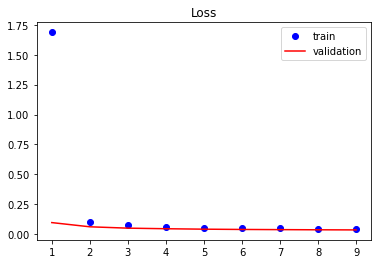

In [17]:
plt.plot(range(1,len(train_losses)+1),train_losses, 'bo', label='train')
plt.plot(range(1,len(val_losses)+1),val_losses, 'r', label='validation')
plt.title('Loss')
plt.legend()

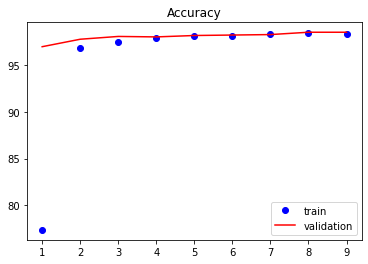

In [18]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy, 'bo', label='train')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy, 'r', label='validation')
plt.title('Accuracy')
plt.legend()

# Understanding what CNN model learns

## Visualizing output from intermediate layer

In [19]:
train_data_loader = torch.utils.data.DataLoader(train, batch_size=16, num_workers=3, shuffle=False)
img,label = next(iter(train_data_loader))

In [20]:
def imshow(inp):
    inp = inp.numpy().transpose((1,2,0))
    mean,std = np.array([0.485,0.456,0.406]),np.array([0.229,0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)

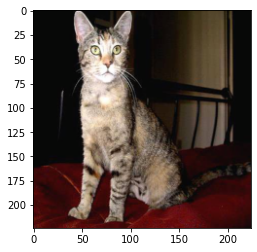

In [21]:
imshow(img[5])

In [22]:
img = img[5][None]

In [23]:
class LayerActivations():
    features=None
    
    def __init__(self,model,layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        self.features = output.cpu().data.numpy()
    
    def remove(self):
        self.hook.remove()

In [24]:
vgg = models.vgg16(pretrained=True)
if is_cuda:
    vgg = vgg.cuda()

In [25]:
conv_out = LayerActivations(vgg.features,0)
o = vgg(Variable(img.cuda()))
conv_out.remove()
act = conv_out.features

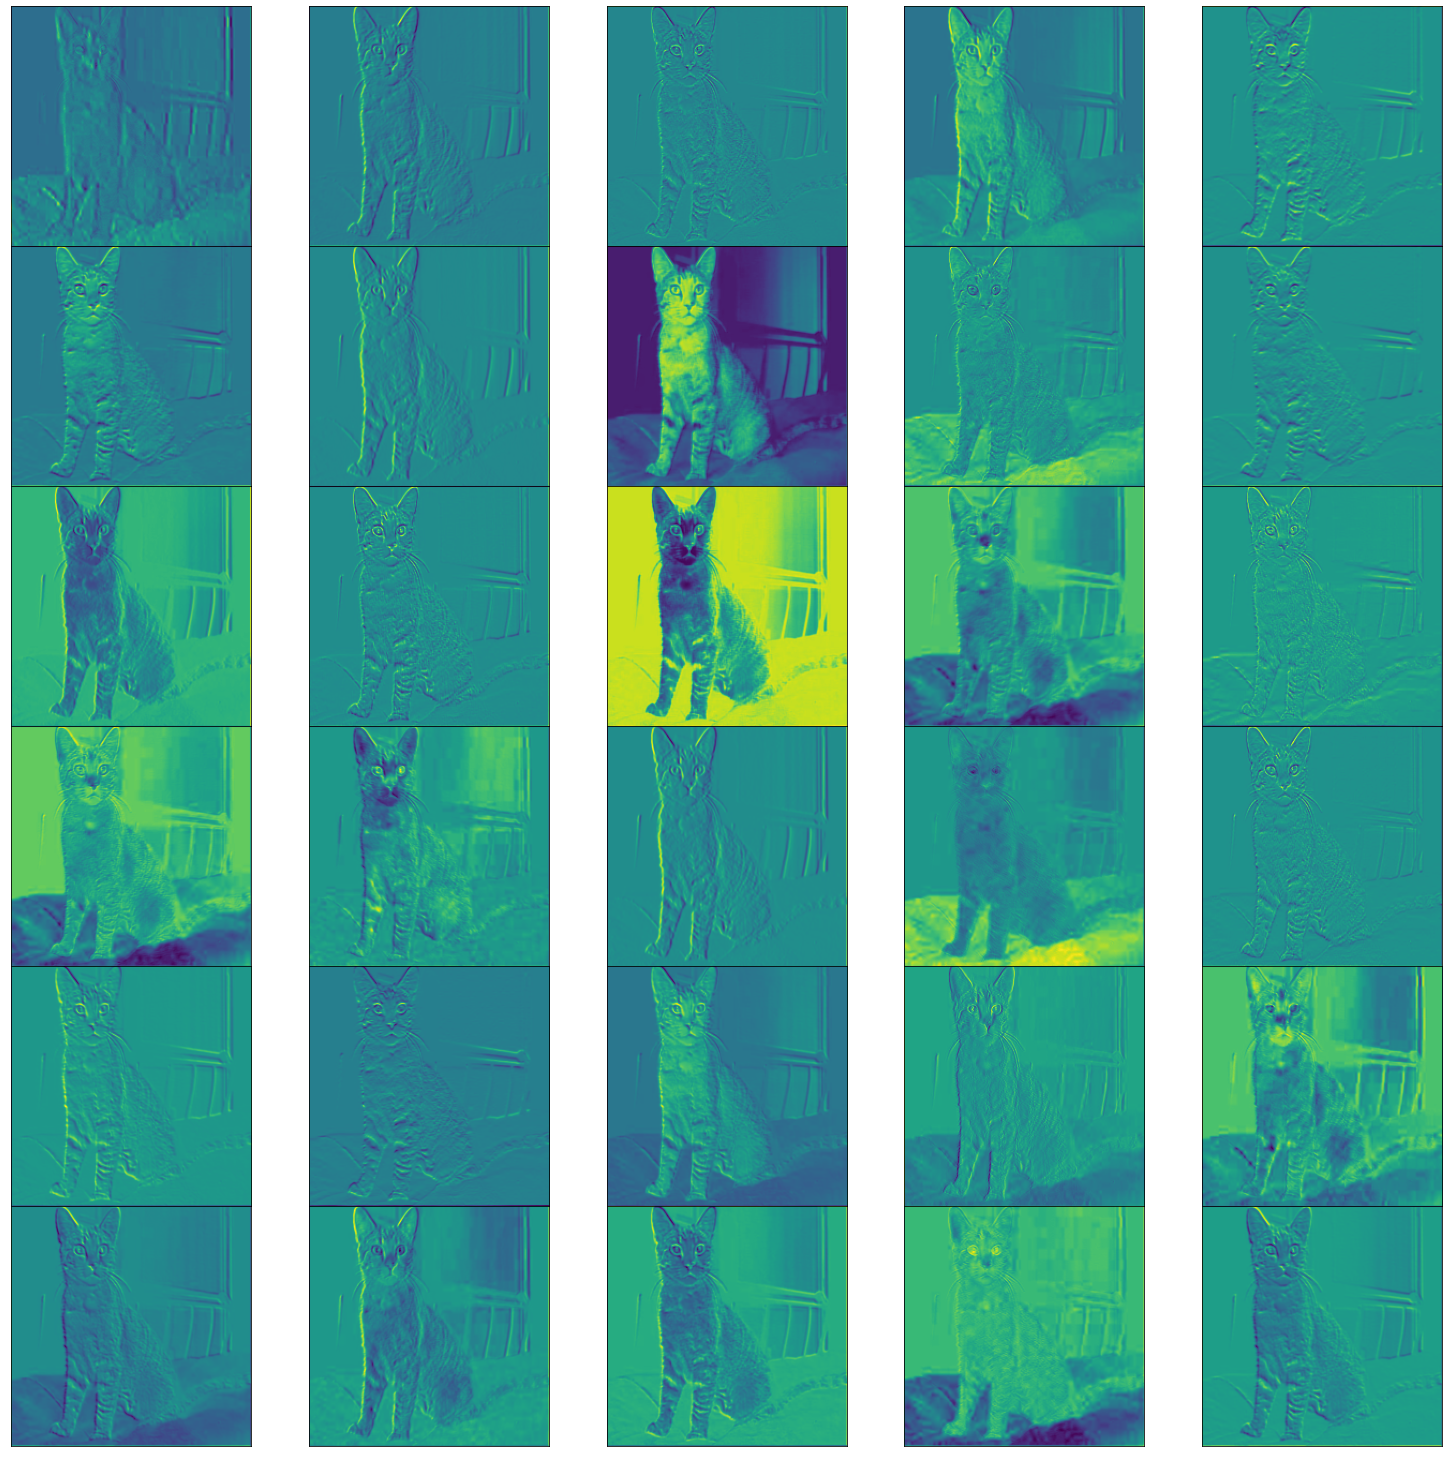

In [26]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)

for i in range(30):
    ax = fig.add_subplot(12, 5, i+1, xticks=[], yticks=[])
    ax.imshow(act[0][i])

- Output of the first convolutional layer

In [27]:
conv_out = LayerActivations(vgg.features,26)
o = vgg(Variable(img.cuda()))
conv_out.remove()
act = conv_out.features

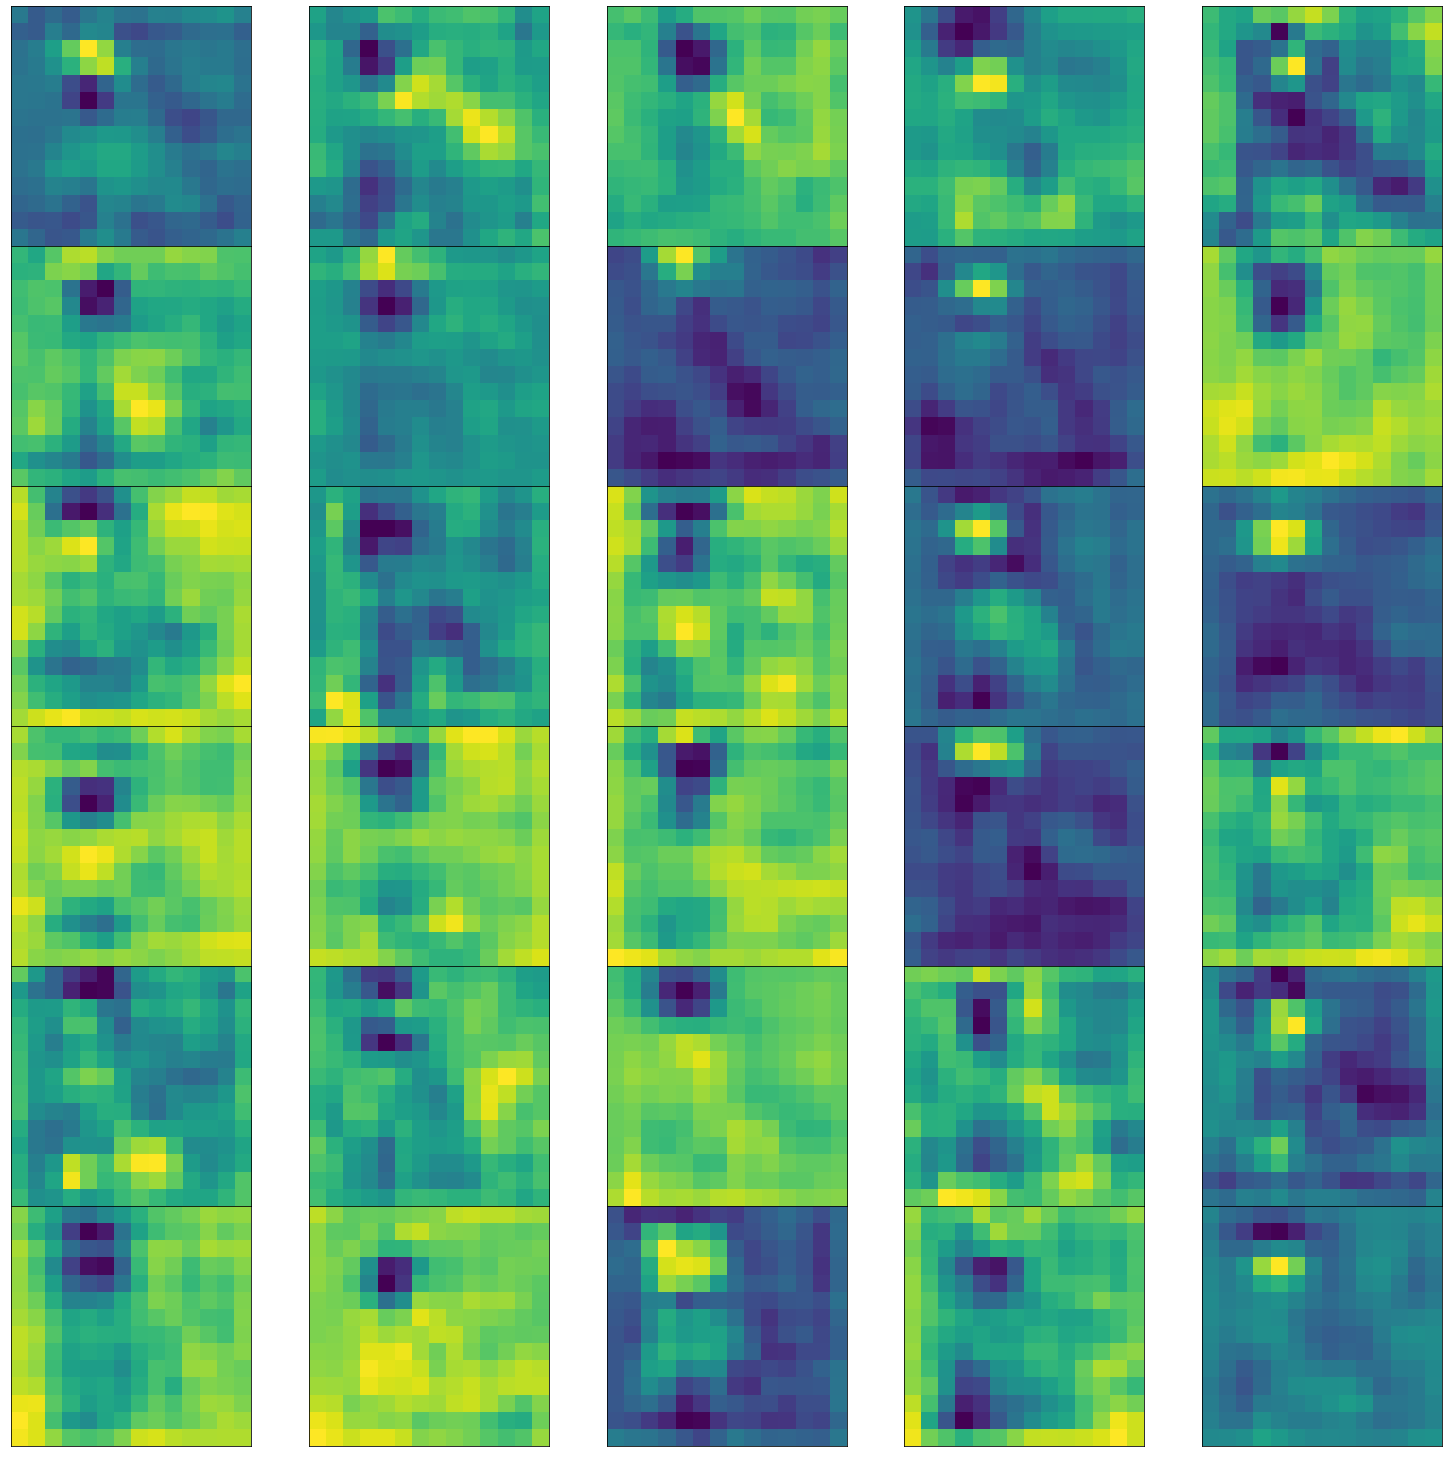

In [28]:
fig = plt.figure(figsize=(20,50))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)

for i in range(30):
    ax = fig.add_subplot(12, 5, i+1, xticks=[], yticks=[])
    ax.imshow(act[0][i])

- Output of the last convolutional layer

## Visualizing weight from intermediate layer

In [29]:
vgg.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])

In [30]:
cnn_weights = vgg.state_dict()['features.0.weight'].cpu()

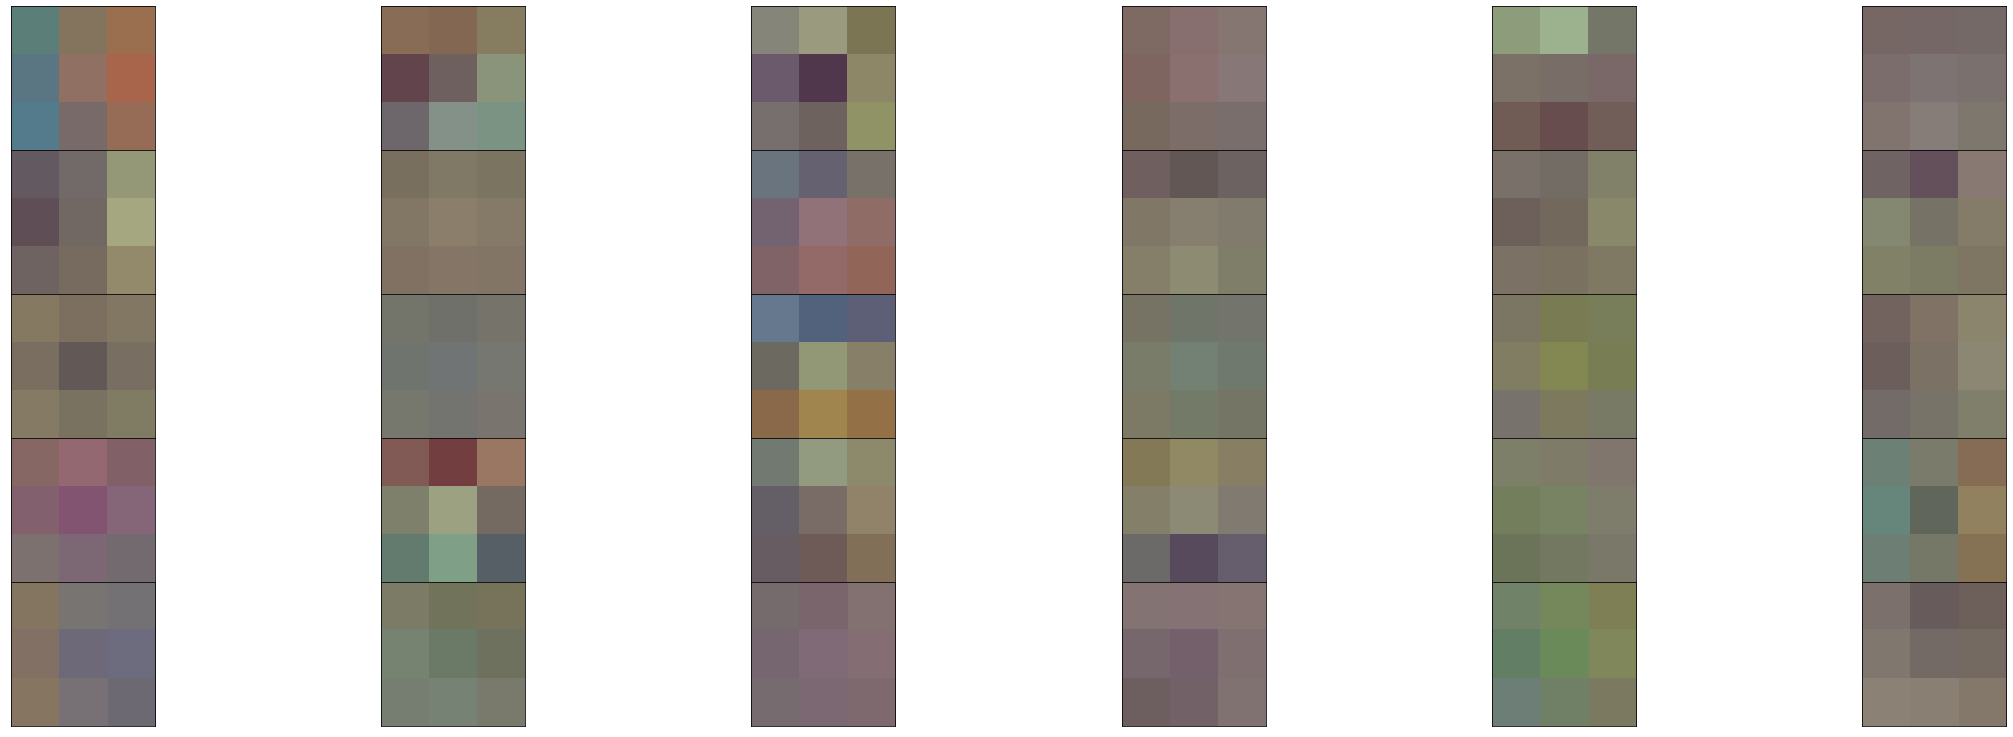

In [31]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)

for i in range(30):
    ax = fig.add_subplot(12, 6, i+1, xticks=[], yticks=[])
    imshow(cnn_weights[i])

In [32]:
cnn_weights.shape

torch.Size([64, 3, 3, 3])